In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
from gridworld.environment import WindyGridworld
from tensorflow import keras
from tqdm.notebook import tqdm
import pandas as pd
import copy


## Learning $\pi_b$ from $\mathcal{D} = \{s,a,s',r\}$

In [2]:
def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']

means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("saved_data/dataset_epsilon_more_concepts.npz") #We're using dataset_large and dataset_knn
print(trajectories.shape)
print(rewards.shape)
print(unique_concepts.shape)
print(concepts.shape)
print(actions.shape)
print(means.shape)
print(clusters.shape)

from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Load some example data
X_train = np.array(clusters)
y_train = np.repeat(np.array([0,1,2,3,4]),100)
X_test = np.array([[1,1], [3,3],[0,-2]])

# Create a kNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=5) #smaller k values results in more fluctuation of the concepts

# Train the classifier
knn.fit(X_train, y_train)


num_concepts = len(means)
env = WindyGridworld(num_concepts=num_concepts, method="simple", knn=None, means=means, policy_model=None, custom_policy=None)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(1090,)
(1090,)
(1090,)
(1090,)
(1090,)
(10, 2)
(500, 2)


# Data pre-processing

In [3]:
A = env.A

def generate_default_dataset(window_size, concept_mapping=None, concept_path=None):
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    Y = actions_indexed.reshape(len(actions_indexed), 1)
    # Y = np.concatenate(actions)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, 4), to_categorical(y_test, 4)

def window_states(trajectories, W_s=30):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    windowed_trajectories = []
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')

def actions_to_action_indexes(actions):
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    indicies = [np.where(np.all((A == a), axis=1))[0][0] for a in actions]
    return np.array(indicies)

## Learning $\pi_b$

### $\pi_b(a|\hat{s})$
Here $\hat{s}$ is the average state over a window of previous states of length $W_s$.
For use in vanilla IS.

In [4]:
from models.policy import PolicyModel

X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5)
print(X_train.shape)
print(y_train.shape)
pi_b = PolicyModel(input_size=X_train[0].shape, num_actions=4).build()
history = pi_b.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
pi_b.save("saved_models/pi_b_10_c")
# pi_b = keras.models.load_model("saved_models/pi_b") 

(338723, 2)
(338723, 4)
Epoch 1/10
8469/8469 [==============================] - 14s 2ms/step - loss: 1.1240 - categorical_accuracy: 0.4680 - val_loss: 1.1173 - val_categorical_accuracy: 0.4746
Epoch 2/10
8469/8469 [==============================] - 10s 1ms/step - loss: 1.1196 - categorical_accuracy: 0.4701 - val_loss: 1.1164 - val_categorical_accuracy: 0.4741
Epoch 3/10
8469/8469 [==============================] - 10s 1ms/step - loss: 1.1188 - categorical_accuracy: 0.4704 - val_loss: 1.1164 - val_categorical_accuracy: 0.4743
Epoch 4/10
8469/8469 [==============================] - 11s 1ms/step - loss: 1.1185 - categorical_accuracy: 0.4710 - val_loss: 1.1170 - val_categorical_accuracy: 0.4726
Epoch 5/10
8469/8469 [==============================] - 15s 2ms/step - loss: 1.1183 - categorical_accuracy: 0.4714 - val_loss: 1.1164 - val_categorical_accuracy: 0.4705
Epoch 6/10
8469/8469 [==============================] - 14s 2ms/step - loss: 1.1181 - categorical_accuracy: 0.4707 - val_loss: 1.11

In [5]:
pi_b.predict(np.array([-3,2]).reshape(1,2))[0]

array([0.29627484, 0.18699566, 0.4410123 , 0.0757172 ], dtype=float32)

In [ ]:
fig, ax2 = plt.subplots(figsize=(16,8))

env.policy_model = pi_b #set policy of agent in the environment

for y in np.linspace(-3,2,2):
    print(y)
    history = env.play(True, [], [], [], [], [], s = np.array([-3, y]))
    print(len(history))
    plt.plot(history[:, 0], history[:, 1])

rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*100
    end = (i+1)*100
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()

### $\pi_b(a|c=f(\hat{s}))$
For use in concept IS. Can also just use default policy used to generate data, inherent to the dataset $\mathcal{D}$, but would like to try both.

In [9]:
from models.policy import PolicyModel

X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5)
#conver to concepts here
concept_model = keras.models.load_model("saved_models/c_10|s")
Xc_train = concept_model.predict(X_train)
Xc_test = concept_model.predict(X_test)
pi_b_c = PolicyModel(input_size=Xc_train[0].shape, num_actions=4).build()
history = pi_b_c.fit(Xc_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
pi_b_c.save("saved_models/pi_b_c_10")
# concept_model = keras.models.load_model("saved_models/c|s")
# pi_b_c = keras.models.load_model("saved_models/pi_b_c")
#                                                                                                                                                                       pi_b_c = keras.models.load_model("saved_models/pi_b_c") 

Epoch 1/10
8469/8469 [==============================] - 12s 1ms/step - loss: 1.1272 - categorical_accuracy: 0.4584 - val_loss: 1.1220 - val_categorical_accuracy: 0.4661
Epoch 2/10
8469/8469 [==============================] - 10s 1ms/step - loss: 1.1254 - categorical_accuracy: 0.4596 - val_loss: 1.1191 - val_categorical_accuracy: 0.4664
Epoch 3/10
8469/8469 [==============================] - 10s 1ms/step - loss: 1.1247 - categorical_accuracy: 0.4597 - val_loss: 1.1186 - val_categorical_accuracy: 0.4561
Epoch 4/10
8469/8469 [==============================] - 10s 1ms/step - loss: 1.1242 - categorical_accuracy: 0.4615 - val_loss: 1.1182 - val_categorical_accuracy: 0.4663
Epoch 5/10
8469/8469 [==============================] - 12s 1ms/step - loss: 1.1240 - categorical_accuracy: 0.4607 - val_loss: 1.1185 - val_categorical_accuracy: 0.4669
Epoch 6/10
8469/8469 [==============================] - 10s 1ms/step - loss: 1.1238 - categorical_accuracy: 0.4612 - val_loss: 1.1182 - val_categorical_acc

In [51]:
input = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
input2 = concept_model.predict(np.array([-3,-3]).reshape(1,2))[0]
print(input)
print(input2)
print("concept: ", np.argmax(input2))
print(pi_b_c.predict(np.array(input).reshape(1,len(input)))) #action probability distribution for a given concept
print(pi_b_c.predict(np.array(input2).reshape(1,len(input))))
# np.mean(pi_b_c.predict(Xc_test), axis=0)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[7.4796796e-26 1.5779015e-24 1.0350836e-20 4.6132747e-23 1.5415290e-07
 9.9999988e-01 4.6301978e-24 0.0000000e+00 3.6892711e-12 5.9694381e-20]
concept:  5
[[0.5542453  0.101693   0.25664628 0.0874154 ]]
[[0.47439256 0.06380202 0.40135124 0.06045419]]


In [268]:
d0 = np.array([0.4281377,  0.07250687, 0.42525867, 0.07409684])
d1 = np.array([0.20833136, 0.20546675, 0.51395243, 0.07224946])
d2 = np.array([0.438365 ,  0.11837474, 0.3666041 , 0.07665614])
d3 = np.array([0.30413994, 0.17288451, 0.4509015,  0.07207396])
d4 = np.array([0.55403537, 0.07854813, 0.28875828, 0.07865817])

print((d0+d1+d2+d3+d4)/5)


[0.38660187 0.1295562  0.409095   0.07474691]


In [31]:
concept_model = keras.models.load_model("saved_models/c_10|s") 
evaluation_env = WindyGridworld(len(means), "simple", knn, means, pi_b_c, None, concept_model)

In [ ]:
history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,-3]))
evaluation_env.plot_trajectory(history,means,clusters)

## Evaluation Policies $\pi_e(a|c=f(\cdot))$ and $\pi_e(a|s)$

These can be created in any way but should try achieve the same goal in the environment as the behavioural policy, and should be created with varying degrees of similarity to the behavioural policy.

### $\pi_e(a|s)$

In [90]:
def eval_policy_a_s(s, A, trajectory=None, concept_model=None, window_states=None):
    s = s.reshape((1,2))
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.13, 0.35, 0.17] #a new distribution of actions, different from behavioural policy

    return A[np.random.choice(indices, 1, p=p)[0]], p

In [ ]:
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, eval_policy_a_s)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,0]))
evaluation_env.plot_trajectory(history,means,clusters)

### $\pi_e(a|c=f(s))$
Note here that the state is at one time step and not average over a window of $W_s$ previous states.

In [ ]:
def policy(s, A, trajectory, concept_model, window_states=None):
    s = s.reshape((1,2))
    c = np.argmax(concept_model.predict(s)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]], p

concept_model = keras.models.load_model("saved_models/c|s") #How can I incorporate future values here? Not possible I dont think. rethink the concept learning using previous values
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,0]))
evaluation_env.plot_trajectory(history,means,clusters)

### $\pi_e(a|c=f(\hat{s}))$
Note here that the state $\hat{s}$ is averaged over a window of $W_s$ previous states.

In [ ]:
def policy(s, A, trajectory, concept_model, window_states):
    '''Arguments:
    s: current state
    A: action space
    trajectory: the trajectory history up until the current state
    concept_model: the model used to predict the current concept
    window_states: function to average previous states in window of length W_s
    '''
    if len(trajectory)==0:
        return s
    s_hat = window_states(trajectory, W_s=10)
    s_hat = s_hat.reshape((1,2))

    c = np.argmax(concept_model.predict(s_hat)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]], p


def window_states(trajectory, W_s):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    i = len(trajectory)
    window = trajectory[i - min(W_s, i):i]
    s_hat = np.sum(window, axis=0)/len(window)
    return s_hat

concept_model = keras.models.load_model("saved_models/c|s") 
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model, window_states)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,-3]))
evaluation_env.plot_trajectory(history,means,clusters)

### $\pi_e(a|c=f(s, s'))$
Note here that the state $s'$ is the previous state.

In [ ]:
def policy(s, A, trajectory, concept_model, window_states):
    '''Arguments:
    s: current state
    A: action space
    trajectory: the trajectory history up until the current state
    concept_model: the model used to predict the current concept
    window_states: function to average previous states in window of length W_s
    '''
    s_input = np.concatenate([s,s])
    if len(trajectory) > 1:
        s_prime = trajectory[len(trajectory)-1]
        s_input = np.concatenate([s,s_prime])

    s_input = s_input.reshape((1,4))    

    c = np.argmax(concept_model.predict(s_input)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]], p


def window_states(trajectory, W_s):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    i = len(trajectory)
    window = trajectory[i - min(W_s, i):i]
    s_hat = np.sum(window, axis=0)/len(window)
    return s_hat

concept_model = keras.models.load_model("saved_models/c|s-s_dash")
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model, window_states)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,-3]))
evaluation_env.plot_trajectory(history,means,clusters)

## Importance Sampling
We need to compute the value and variance of:
* $V_{IS}$
* $V_{PDIS}$
* $V_{IS}^{concept}$
* $V_{PDIS}^{concept}$

Intuitively, a conceptual region covers more area in the state space and hence there should be more overlap between the behavioural and evaluation policies, and therefore less variance. Note that certain concepts may result in less variance while others may not. We will then need to optimise over the concepts to find the set which reduce the variance the most.

The below formulation is of per-decision importance sampling (PDIS). We need to construct the formulation of vanilla IS too. 

$$
\hat{V}_{IS}^{\pi_e}(\mathcal{D}) = \frac{1}{|\mathcal{D}|}\sum_{\tau \in \mathcal{D}} g(\tau)\rho(\tau)
$$
where
$$
\rho(\tau) = \prod_{t=1}^{T}\frac{\pi_e(a_t|s_t)}{\pi_b(a_t|s_t)}
$$
and
$$
g(\tau) = \sum_{t=1}^{T} \gamma^{t-1}r_t.
$$

Here $\gamma$ is the discount factor and $\tau \sim \pi_b$

In [14]:
unique_concept_combinations_visited = []

for comb in unique_concepts:
    if comb not in unique_concept_combinations_visited:
        unique_concept_combinations_visited.append(comb)
print(f"Number of unique concept combinations visited {len(unique_concept_combinations_visited)}")
mean_reward_per_combination = np.zeros(len(unique_concept_combinations_visited))
combination_occurence = np.zeros(len(unique_concept_combinations_visited))
unique_concept_combinations_visited

concepts_to_trajectories_mapping = {}
for combination in unique_concepts:
    concepts_to_trajectories_mapping[tuple(combination)] = []


for idx, concept_list in enumerate(unique_concepts):
    concepts_to_trajectories_mapping[tuple(concept_list)].append(idx)

print(concepts_to_trajectories_mapping.keys())
len(concepts_to_trajectories_mapping[(1, 3, 4, 7, 9)]) #try (0,1,3) (good) and (0,4) (bad)

Number of unique concept combinations visited 16
dict_keys([(1, 3, 4, 7, 9), (1, 2, 3, 4, 7, 9), (0, 2, 6, 7, 9), (0, 2, 5, 7, 8, 9), (1, 2, 5, 7, 8, 9), (2, 3, 4, 7, 9), (1, 2, 4, 7, 9), (2, 5, 7, 8, 9), (3, 4, 7, 9), (1, 4, 7, 9), (1, 4, 5, 7, 8, 9), (2, 6, 7, 9), (1, 2, 3, 4, 9), (2, 3, 4, 9), (0, 6, 7, 9), (1, 2, 5, 7, 9)])


320

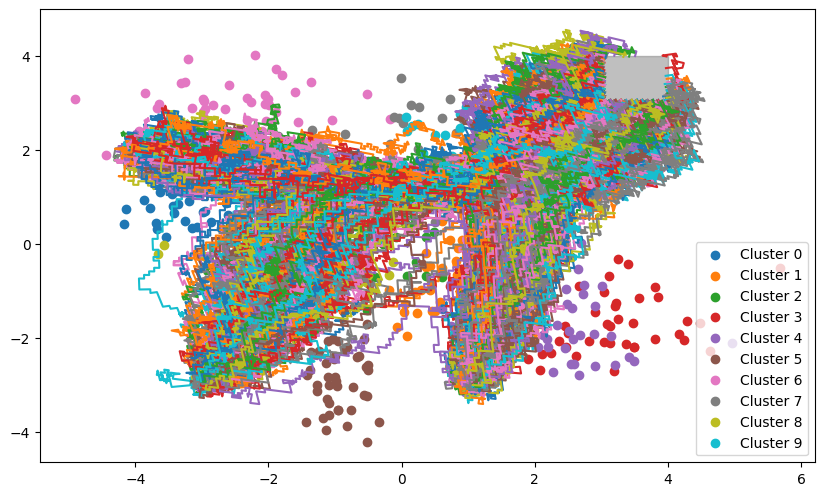

320


In [27]:
def plot_trajectories(trajectories, means, clusters):
        fig, ax = plt.subplots(figsize=(10,6), dpi=100)
        for history in trajectories:
            plt.plot(history[:, 0], history[:, 1])
    
        rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
        ax.add_patch(rect)
        for i in range(len(means)):
            points_in_clusters = int(len(clusters)/len(means))
            start = i*points_in_clusters
            end = (i+1)*points_in_clusters
            plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

        plt.legend()
        plt.show()
trajectory_subset = trajectories[concepts_to_trajectories_mapping[(1, 3, 4, 7, 9)]]
plot_trajectories(trajectories, means, clusters)
print(len(trajectory_subset))

In [39]:

def pre_process(trajectories_original, actions_original, concept_model=None, pi_b=None,  pi_b_c=None, concept_mapping=None, concept_path=None):
    behaviour_distributions = []
    evaluation_distributions = []
    action_indicies = []
    trajectories = copy.deepcopy(trajectories_original)
    actions = copy.deepcopy(actions_original)

    subset_indicies = []
    if concept_mapping:
        subset_indicies = concept_mapping[concept_path]
        trajectories = trajectories[subset_indicies] #selects subset of trajectories which travelled through a certain path of concepts
        actions = actions[subset_indicies]
        

    print("Pre-processing data....")
    for idx in range(len(trajectories)):
        completed_actions = actions[idx]
        trajectory = trajectories[idx]
        action_indicies.append(actions_to_action_indexes(completed_actions))

        if concept_model is not None:
            concepts = predict_concepts_from_states(trajectory, concept_model)
            behaviour_distributions.append(predict_actions_from_concepts(concepts, pi_b_c))
        else:
            behaviour_distributions.append(predict_actions_from_states(trajectory, pi_b))
    
    evaluation_distributions = copy.deepcopy(behaviour_distributions)
    print("Finished.")
    return behaviour_distributions, evaluation_distributions, action_indicies, trajectories, subset_indicies


def actions_to_action_indexes(actions):
    up = [0, 1]
    down = [0, -1]
    right = [1, 0]
    left = [-1, 0]
    A = np.array([up, down, right, left]) #action space
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    return np.array([np.where(np.all((A == a), axis=1))[0][0] for a in actions])

def predict_concepts_from_states(trajectory, concept_model):
    return np.array(concept_model.predict(trajectory))

def predict_actions_from_states(trajectory, pi_b):
    return np.array(pi_b.predict(trajectory)) 
    # self.evaluation_distributions = np.copy(self.behaviour_distributions)

def predict_actions_from_concepts(concepts, pi_b_c):
    return np.array(pi_b_c.predict(concepts))


class Estimator():

    up = [0, 1]
    down = [0, -1]
    right = [1, 0]
    left = [-1, 0]
    A = np.array([up, down, right, left]) #action space

    def __init__(self, trajectories_subset, behaviour_distributions, evaluation_distributions, action_indicies, *args, **kwargs):
        self.trajectories = trajectories_subset
        self.behaviour_distributions = copy.deepcopy(behaviour_distributions)
        self.evaluation_distributions = copy.deepcopy(evaluation_distributions)
        self.action_indicies = copy.deepcopy(action_indicies)
        self.args = args
        self.kwargs = kwargs

    def IS():
        pass

    def PDIS(self, D, eval_policy):   
        value_estimate = 0
        on_policy_value = 0
        total_likelihood_ratios=0
        non_unit_likelihood_ratios=0
        observed_evaluation_distributions = []

        for t in (range(D)):
            behaviour_dist = self.behaviour_distributions[t]
            behaviour_trajectory = self.trajectories[t]
            T = len(behaviour_dist) #trajectory length
            evaluation_dist = self.evaluation_distributions[t]
            action_idxs = self.action_indicies[t]

            product, count, evaluation_distributions_copy =  self.rho(behaviour_trajectory, action_idxs, behaviour_dist, evaluation_dist, eval_policy)
            sum = self.g(T)
            value_estimate += sum  * product
            on_policy_value += sum
            non_unit_likelihood_ratios+= count
            total_likelihood_ratios += T
            observed_evaluation_distributions.append(evaluation_distributions_copy)

        return value_estimate/D, (non_unit_likelihood_ratios/total_likelihood_ratios)*100, on_policy_value/D, observed_evaluation_distributions

    def rho(self, behaviour_trajectory, actions_idx, behaviour_dist, evaluation_dist, eval_policy):
        product = 1
        count = 0

        r,_ = behaviour_dist.shape
        behaviour_probabilities = behaviour_dist[np.arange(r), actions_idx]
        evaluation_dist_copy = copy.deepcopy(evaluation_dist)
        # print(len(evaluation_dist), len(behaviour_dist), len(behaviour_trajectory))
        for j in range(len(evaluation_dist)):
        #     epsilon = 0.5
        #     dist_index = np.random.choice([0,1],1,p=[1-epsilon,epsilon])[0]
        #     if dist_index == 1:
        #         replacement_distribution = eval_policy 
        #         evaluation_dist_copy[j] = replacement_distribution
            
            if behaviour_trajectory[j][0] < -1 and behaviour_trajectory[j][1] < -1:
                epsilon = 0.7
                dist_index = np.random.choice([0,1],1,p=[1-epsilon,epsilon])[0]
                if dist_index == 1:
                    evaluation_dist_copy[j] = eval_policy 
                    
            
        
        r,_ = evaluation_dist_copy.shape
        evaluation_probabilities = evaluation_dist_copy[np.arange(r), actions_idx]
        ratios = np.array(evaluation_probabilities/behaviour_probabilities)
        product = np.prod(ratios)
        count = len(np.where(ratios<0.8)[0])
        
        return product, count, evaluation_dist_copy

    def g(self, T, gamma=1):
        r_t = -1
        return T*r_t

In [33]:
behaviour_distributions, evaluation_distributions, action_indicies, trajectories_subset, subset_indicies = pre_process(
    trajectories[0:1000],
    actions,
    None,
    pi_b,
    None,
    concept_mapping=None,
    concept_path=None
)
behaviour_distributions_c, evaluation_distributions_c, action_indicies_c, trajectories_subset_c, subset_indicies = pre_process(
    trajectories[0:1000],
    actions,
    concept_model,
    pi_b,
    pi_b_c,
    concept_mapping=None,
    concept_path=None)

print("Dataset size: ",len(behaviour_distributions))

Pre-processing data....
Finished.
Pre-processing data....
Finished.
Dataset size:  1000


In [68]:
def reject_outliers(data, m = 4.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    # print(s)
    return data[s<m]

estimator = Estimator(trajectories_subset=trajectories_subset,behaviour_distributions=behaviour_distributions, evaluation_distributions=evaluation_distributions, action_indicies=action_indicies)
concept_estimator = Estimator(trajectories_subset=trajectories_subset, behaviour_distributions=behaviour_distributions_c, evaluation_distributions=evaluation_distributions_c, action_indicies=action_indicies)

dataset_sizes = [100, 300, 500, 700, 850]
dataset_sizes = [ 300, 500, 700]
num_trials = 100
data = {}
data_no_outliers = {}

for D in dataset_sizes:
    values1, values2, ess_values1, ess_values2 = [], [], [], []
    for i in tqdm(range(num_trials)): 
        #[0.25,0.1,0.4,0.25] 
        eval_policy = [0.25,  0.1, 0.55 ,  0.1 ]  # [0.38660187, 0.1295562,  0.409095 ,  0.07474691], [0.438365   0.11837474 0.3666041  0.07665614] is the actual distributoin over concepts in this region
        estimate, small_weights, on_policy_value, observed_evaluation_distributions = estimator.PDIS(D, eval_policy=eval_policy)
        estimate_concepts, small_weights_concepts, on_policy_value_concepts, observed_evaluation_distributions_concepts = concept_estimator.PDIS(D, eval_policy=eval_policy)
        values1.append(estimate)
        values2.append(estimate_concepts)
        ess_values1.append(small_weights)
        ess_values2.append(small_weights_concepts)
    values1 = np.array(values1)
    values2 = np.array(values2)
    data[f"{D}_vanilla"] = values1
    data[f"{D}_concepts"] = values2
    data_no_outliers[f"{D}_vanilla"] = reject_outliers(values1)
    data_no_outliers[f"{D}_concepts"] = reject_outliers(values2)
    print(f"Mean weights smaller than 0.8: {np.array(ess_values1).mean()}%")
    print(f"Mean weights smaller than 0.8 concepts: {np.array(ess_values2).mean()}%")
    print("On policy: ",on_policy_value)
    print("On policy over concepts: ", on_policy_value_concepts)



Mean weights smaller than 0.8: 1.4563100148913954%
Mean weights smaller than 0.8 concepts: 1.4557879602211454%
On policy:  -389.4866666666667
On policy over concepts:  -389.4866666666667



Mean weights smaller than 0.8: 1.4279127450122728%
Mean weights smaller than 0.8 concepts: 1.430496019595836%
On policy:  -388.654
On policy over concepts:  -388.654



Mean weights smaller than 0.8: 1.3684135102958683%
Mean weights smaller than 0.8 concepts: 1.3694754324852656%
On policy:  -388.78285714285715
On policy over concepts:  -388.78285714285715


In [ ]:

for i in range(50):
    print((observed_evaluation_distributions_concepts[7][i]))

In [70]:
# data = {"vanilla":values1,"concepts":values2, "vanilla_no_outliers":reject_outliers(values1),"concepts_no_outliers":reject_outliers(values2)}
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data.items() ]))
df_no_outliers = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data_no_outliers.items() ]))

print("With outliers")
print(df.describe())
print("Without outliers")
print(df_no_outliers.describe())



With outliers
       300_vanilla  300_concepts  500_vanilla  500_concepts  700_vanilla  \
count   100.000000    100.000000   100.000000    100.000000   100.000000   
mean   -323.533012   -318.015353  -325.921085   -317.965517  -342.861659   
std      29.443520      8.306803    55.922637      8.541454   235.334878   
min    -566.114204   -361.682748  -832.912874   -374.047239 -2671.285889   
25%    -319.564674   -317.379038  -318.254344   -317.918382  -318.870379   
50%    -315.606096   -315.099136  -315.113184   -314.555743  -316.794361   
75%    -314.619764   -314.229154  -314.016253   -313.905999  -316.297717   
max    -313.634542   -313.588304  -313.499630   -313.515593  -315.803038   

       700_concepts  
count    100.000000  
mean    -318.879896  
std        7.019984  
min     -366.838184  
25%     -318.423133  
50%     -316.933758  
75%     -316.270589  
max     -315.901813  
Without outliers
       300_vanilla  300_concepts  500_vanilla  500_concepts  700_vanilla  \
count    8

In [158]:
# df.to_parquet("parquets/policy_experiments/ope_estimates_contrarian_policy")
# df_no_outliers.to_parquet("parquets/policy_experiments/ope_estimates_contrarian_policy_no_outliers")

In [52]:
num_concepts = 5
eval_env = WindyGridworld(
    num_concepts=num_concepts,
    method="simple",
    knn=knn,
    means=means,
    policy_model=pi_b,
    concept_model=None,
    epsilon=0.3,
    eval_epsilon=0.7,
    eval_distribution=[0.25,  0.1, 0.55 ,  0.1 ] ,
)

eval_trajectories = []
eval_rewards = []
eval_unique_concepts = []
eval_concepts = []
eval_actions = []


# Create dataset in windy gridworld
for j in tqdm(range(10)):
    starting_positions = [np.array([-3, -3]), np.array([-4, 2]), np.array([1, -3])]
    s = starting_positions[np.random.choice([0, 1, 2], 1)[0]]
    s=np.array([-3, -3])
    eval_env.play(
        True,
        eval_trajectories,
        eval_rewards,
        eval_unique_concepts,
        eval_concepts,
        eval_actions,
        s=s,
        use_eval_policy=True,
    )

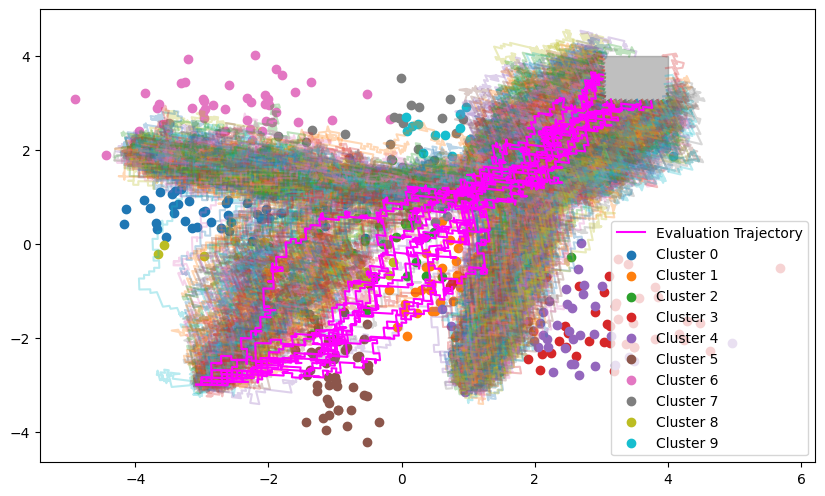

In [54]:
def plot_eval_trajectories(eval_trajectories,trajectories):
    fig, ax = plt.subplots(figsize=(10,6), dpi=100)
    
    
    for history in trajectories:
        plt.plot(history[:, 0], history[:, 1], alpha=0.3)

    for history in eval_trajectories:
        plt.plot(history[:, 0], history[:, 1], color="magenta")
    plt.plot(history[0, 0], history[0, 1], color="magenta", label="Evaluation Trajectory") #for legend purposes

    rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
    ax.add_patch(rect)
    for i in range(len(means)):
        num_points = int(len(clusters)/len(means))
        start = i*num_points
        end = (i+1)*num_points
        plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

    plt.legend()
    plt.show()

plot_eval_trajectories(eval_trajectories, trajectories_subset)

In [55]:
lengths = [len(eval_traj) for eval_traj in eval_trajectories]
print(lengths)
print(np.array(lengths).mean())

[335, 299, 284, 299, 354, 305, 318, 311, 295]
311.1111111111111
